# Проверочная работа. Бинарная классификация

Работа с данными банка Satander 
Описание исходной задачи: https://www.kaggle.com/c/santander-customer-satisfaction

Загрузить данные 
- Провести описательный анализ предложенных данных
- Провести анализ корреляции переменных, отобразить взаимосвязи между переменными
- Провести стратегию Feature Selection (попробовать как минимум два различных подхода)
- Шкалировать данные несколькими способами (нормализация, стандартизация). Какой подход лучше?
- Попробовать стратегию oversamling и сравнить ее с неизмененной моделью
- Попробовать стратегию undersampling и сравнить ее с неизмененной моделью
- Сделать кросс-валидацию тренировочных данных с использованием подхода K-fold (n_folds=10)
- Решить задачу бинарной классификации и предсказать удовлетворение клиентов банка (переменная TARGET)
- Рассчитать Feature Importances для переменных модели
- Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
- Построить Confusion Matrix для ваших результатов
- Загрузить ipython notebook с результатами работы на github репозиторий

#### В рамках этой задачи решается проблема бинарной классификации данных. Необходимо выбрать лояльных клиентов

## 0. Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import re

%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Загрузка данных

In [ ]:
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

## 2. Анализ данных

In [ ]:
print("Количество признаков в исходной выборке: {0} ".format(len(train.columns)))

Признаков весьма много. Однако не трудно заметить, что их наименование стандартно и начинается с некоторых префиксов. Изучим префиксы, которые есть в датасете:

Перед тем как начать работать с группами признаков, определимся какие параметры для нас не интересны. Удалим все константные параметры, для которых 99,9% выборки - константное значение

In [ ]:
#Перед тем как удалять константные значения, создадим новый признак - количество нулей в параметрах
train['mc0'] = (train[[i for i in train.columns if 'TARGET' not in i]] == 0).astype(int).sum(axis=1)

In [ ]:
test['mc0'] = (test[[i for i in test.columns if 'TARGET' not in i]] == 0).astype(int).sum(axis=1)

In [ ]:
#Удалим все параметры, для которых 99,9% выборки - константное значение
train = train.drop([i for i in train.columns if train[i].value_counts().iloc[0]/len(train)>0.999], axis=1)

In [ ]:
print("Количество признаков в выборке после удаления константных параметров: {0} ".format(len(train.columns)))

In [ ]:
train.describe()

После удаления всех константных признаков, остались следующие признаки:

In [ ]:
columns = pd.DataFrame([re.split('_', i)[0] for i in train.columns.values], columns=['prefix'])
columns['cnt'] = 1
columns.groupby('prefix').count().sort_values('cnt', ascending=False)

#### В полученном массиве есть прификсы и уникальные переменные.
Префиксы:
 - num	(94 признака) - количественные признаки
 - ind	(53 признаков) - индикаторы
 - saldo	(46 признак) - остаток
 - imp	(21 признаков) - количество
 - delta	(4 признаков) - разница параметра между двумя периодами

Уникальные переменные - 
- ID - уникальный идентификатор
- TARGET - целевая переменная
- var15	- предполагается что это возраст клиента (https://www.kaggle.com/c/santander-customer-satisfaction/discussion/19291#110414)
- var21	-
- var3	-
- var36	-
- var38	-

Изучим отдельные группы признаков из датасета. В первую очередь начнем с уникальных переменных

##### 2.1 TARGET - Целевая переменная: Проверяем сбалансированность датасета

In [ ]:
df = pd.DataFrame(train.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train.shape[0]
df

In [ ]:
train.TARGET.hist()

Очевидно, что датасет не сбалансирован, что может привести к переобучению. В дальнейшем попробуем применить Undersampling и Oversmapling

##### 2.2 var15

var15 - предполагается что это возраст клиента (https://www.kaggle.com/c/santander-customer-satisfaction/discussion/19291#110414)


In [ ]:
train.var15.value_counts().head(5)

Уберем наиболее часто встречающееся значение - 23. После этого гистограмма респределения клиентов становится более похожей на нормальное распределние.

При разбиении гистограммы на две части по Target переменной, становится ясно что люди более старшего возраста менее довольны услугами банка

In [ ]:
sns.FacetGrid(train.loc[(train['var15']!=23)], hue="TARGET", height=5)\
        .map(sns.kdeplot, "var15")\
        .add_legend()

По результатам анализа параметра, сделаем дополнительную фичу:
- var15mc - индикатор, 1 в случае если var15=23

train['var15mc'] = train.apply(lambda row: 1 if row['var15']==23 else 0, axis=1)

##### 2.2 var21

In [14]:
# Посмотрим на распределение значений для данной фичи в датасете
df = pd.DataFrame(train.var21.value_counts())
df['Percentage'] = 100*df['var21']/train.shape[0]
df.head(5)

,var21,Percentage
0,75152,98.858195
900,236,0.310445
1800,206,0.270981
4500,96,0.126283
3000,84,0.110497


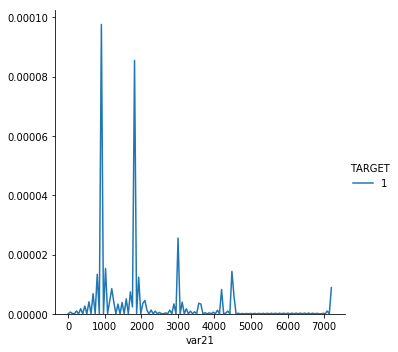

In [15]:
# Гистограмма 
sns.FacetGrid(train[(train['TARGET']!=0)], hue="TARGET", height=5)\
        .map(sns.kdeplot, "var21")\
        .add_legend()

Определенной зависимости из  var21 выделить не удалось, однако можно сделать дополнительную фичу, поскольку 98% значений являются одинаковыми:
- var21mc , 1 если var21=0

train['var21mc'] = train.apply(lambda row: 1 if row['var21']==0 else 0, axis=1)

##### 2.3 var3

In [16]:
# Посмотрим на наиболее распространенный тип данных для 
train.var3.value_counts().head(5)

 2         74165
 8           138
-999999      116
 9           110
 3           108
Name: var3, dtype: int64

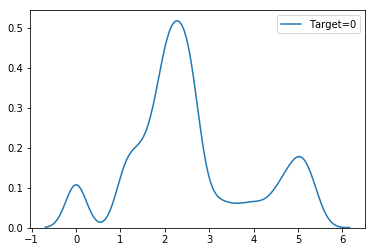

In [17]:
# Уберем наиболее распространенный тип данных и ошибку (-999999), после чего изучим гистограмму
sns.kdeplot(train[(train['var3']!=-999999) & (train['var3']!=2) ]['var3'].map(np.log)\
            .rename("Target=0"), legend=True)

Для дальнейшего проведения анализа, заменим ошибку на наиболее распространенный класс и сделаем новую фичу:
- var3mc, 1 если var3=0


train['var3mc'] = train.apply(lambda row: 1 if row['var3']==0 else 0, axis=1)

##### 2.4 var36

In [18]:
train.var36.value_counts()

99    30064
3     22177
1     14664
2      8704
0       411
Name: var36, dtype: int64

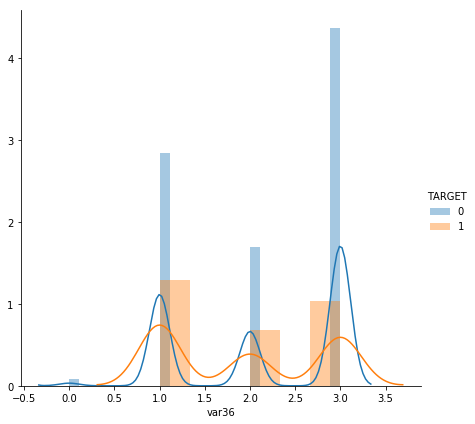

In [19]:
# train[(train['var36']!=99)]['var36'].hist()
sns.FacetGrid(train[(train.var36 != 99) ], hue="TARGET", height=6)\
    .map(sns.distplot, "var36")\
    .add_legend()

Признак var36 очень похож на категориальный, поэтому лучше всего его разнести по нескольким столбцам с помощью One-hot encoding

cat_columns = ['var36']

for i in cat_columns:
    new_columns = pd.get_dummies(train[i], prefix=i)
    train = pd.concat([train, new_columns], axis=1)
    
train = train.drop(cat_columns, axis=1)

##### 2.5 var38

In [20]:
# Посмотрим на значения параметра var38
train.var38.value_counts().head(5)

117310.979016    14868
451931.220000       16
463625.160000       12
288997.440000       11
104563.800000       11
Name: var38, dtype: int64

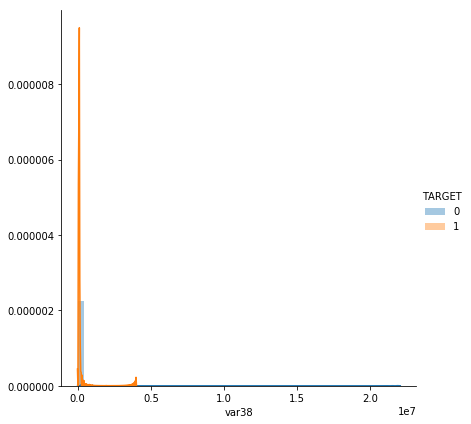

In [21]:
# Если взять распределение параметра var38, то получится не очень информативный график
sns.FacetGrid(train, hue="TARGET", height=6)\
    .map(sns.distplot, "var38")\
    .add_legend()

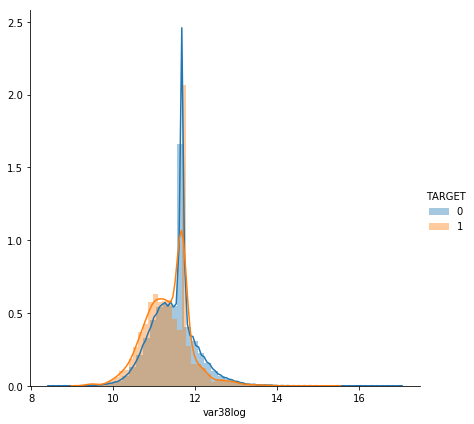

In [22]:
# Возьмем логарифм от параметра var38:

sns.FacetGrid(train.assign(var38log=train.var38.map(np.log)),  hue="TARGET" , height=6)\
    .map(sns.distplot, "var38log")\
    .add_legend()


Как видно из графика, распределение фактически является нормальным, за исключением выброса. Скорее всего этот выброс - результат большого количества значений 117310.979016 в признаке var38

Попробуем убрать выброс, исключив из выборки все значения, близкие к 117310.979016

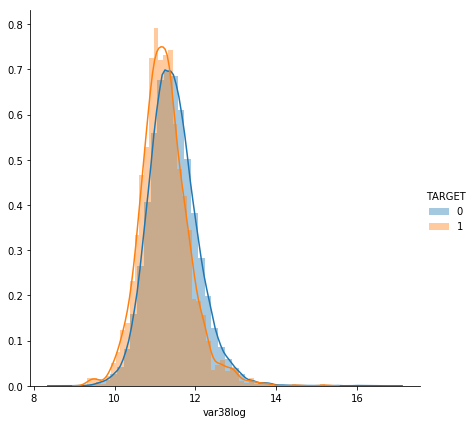

In [23]:
sns.FacetGrid(train[~np.isclose(train.var38, 117310.979016)].assign(var38log=train.var38.map(np.log)),  hue="TARGET" , height=6)\
    .map(sns.distplot, "var38log")\
    .add_legend()

График стал максимально похожим на нормальное распределение

Похоже, что var38 является чем-то похожим на кредитный рейтинг клиента (а возможно - нет).
Выделим две фичи из параметра var38:

- var38log - в случае если значение не рядом с 117310.97901, то логарифм от параметра
- var38mc - наиболее популное значение переменной, рядом со значением 117310.97901

train['var38mc'] = train.apply(lambda row: 1 if row['var3']==0 else 0, axis=1)
train['var38log'] = train.apply(lambda row: np.log(row['var38']), axis=1)

##### 2.6 Группы признаков. delta (26 признаков) 

In [24]:
train[[i for i in train.columns if "delta" in i]].describe()

,delta_imp_aport_var13_1y3,delta_imp_compra_var44_1y3,delta_num_aport_var13_1y3,delta_num_compra_var44_1y3
count,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04
mean,4.867140e+07,9.208103e+06,4.867140e+07,9.208103e+06
std,6.959537e+08,3.033108e+08,6.959537e+08,3.033108e+08
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000000e+10,1.000000e+10,1.000000e+10,1.000000e+10


In [25]:
columns = [i for i in train.columns if 'delta' in i ]
NUM = len(columns)
COLS = 4
ROWS = round(NUM/COLS) 

for k in range(0, ROWS-1):
    plt.subplots(1, COLS, figsize=(20,5))
    for j in range(1, COLS+1):
        i=k*4+(j)
        plt.subplot(1, COLS, j)
        plt.title(columns[i]) 
        sns.kdeplot(train[(train.TARGET==0)][columns[i]].rename("Target=0"), legend=True)
        sns.kdeplot(train[(train.TARGET==1)][columns[i]].rename("Target=1"), legend=True)

##### 2.7 Группы признаков. imp (49 признаков) - количество  

In [26]:
#Выберем все константные переменные - от них нам предстои избавиться в дальнейшем
train[[i for i in train.columns if 'imp' in i ]].describe()

,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,...,imp_op_var39_ult1,imp_sal_var16_ult1,delta_imp_aport_var13_1y3,delta_imp_compra_var44_1y3,imp_aport_var13_hace3,imp_aport_var13_ult1,imp_var7_recib_ult1,imp_compra_var44_ult1,imp_var43_emit_ult1,imp_trans_var37_ult1
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04
mean,86.208265,72.363067,119.529632,3.559130,6.472698,3.160715,68.803937,113.056934,68.205140,113.225058,...,140.403479,5.477676,4.867140e+07,9.208103e+06,2823.949089,619.585010,1.276982e+02,1.167825e+02,8.541207e+02,1.932954e+03
std,1614.757313,339.315831,546.266294,93.155749,153.737066,95.268204,319.605516,512.154823,531.897917,950.086398,...,712.767240,465.391149,6.959537e+08,3.033108e+08,25334.468106,11252.995089,6.368997e+03,1.362044e+04,1.425589e+04,2.535572e+04
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000e+00,-1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,8237.820000,12888.030000,16566.810000,45990.000000,131100.000000,...,47598.090000,105000.000000,1.000000e+10,1.000000e+10,840000.000000,450000.000000,1.039260e+06,3.410059e+06,1.155003e+06,2.310003e+06


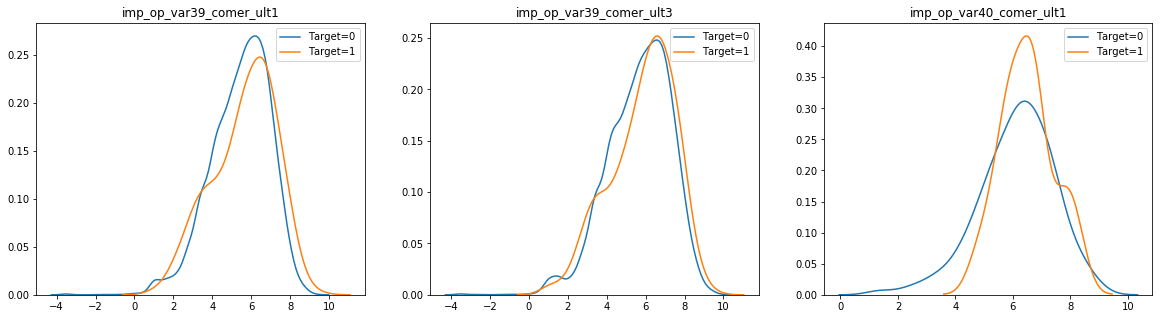

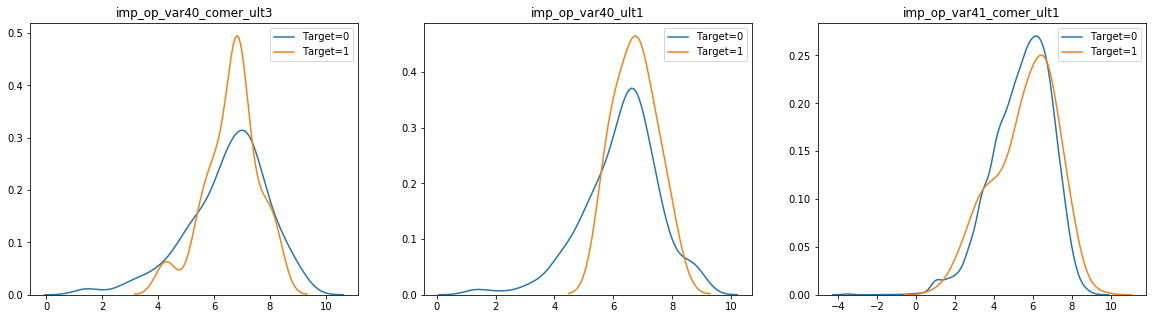

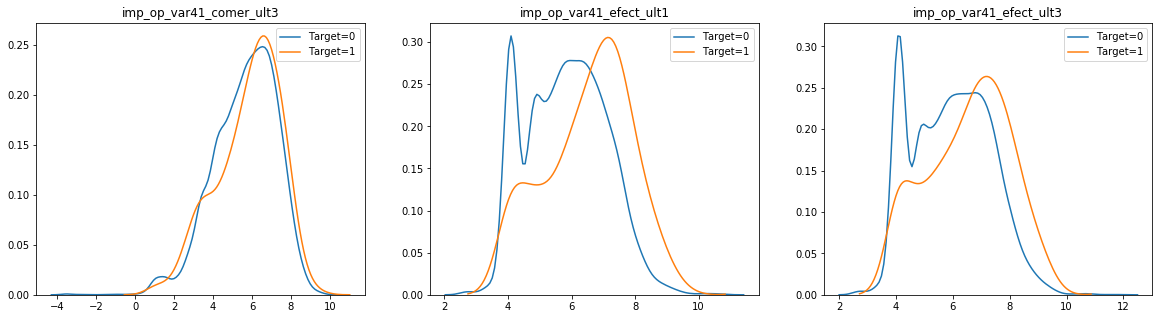

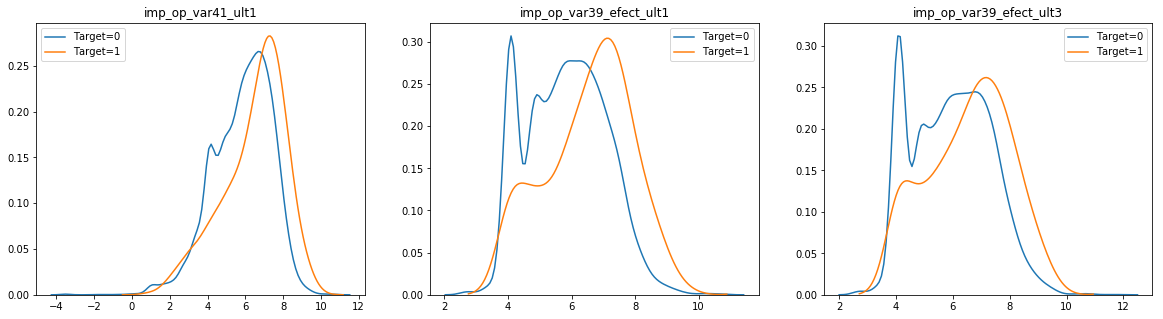

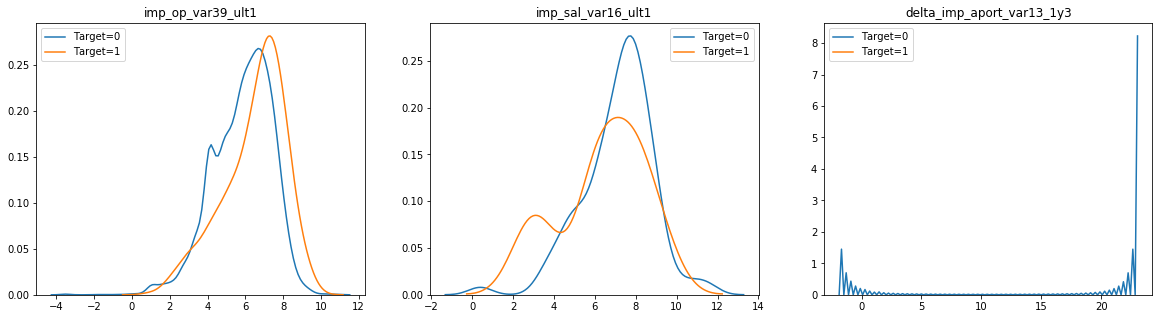

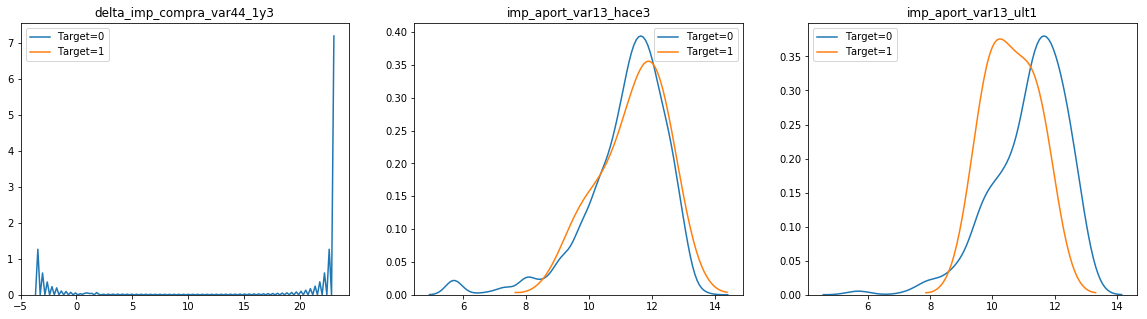

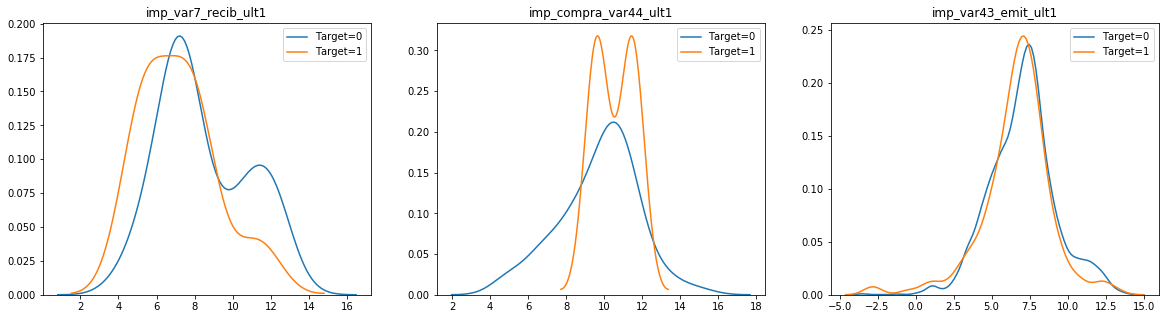

In [27]:
columns = [i for i in train.columns if 'imp' in i ]
NUM = len(columns)
COLS = 3
ROWS = round(NUM/COLS) 

for k in range(0, ROWS-1):
    plt.subplots(1, COLS, figsize=(20,5))
    for j in range(1, COLS+1):
        i=k*3+(j)
        plt.subplot(1, COLS, j)
        plt.title(columns[i]) 
        sns.kdeplot(train[(train.TARGET==0)][columns[i]].map(np.log).rename("Target=0"), legend=True)
        sns.kdeplot(train[(train.TARGET==1)][columns[i]].map(np.log).rename("Target=1"), legend=True)

При преобразовании большинства признаков, распределение сходится к нормальному. 
Таким образом все признаки, за исключением следующих преобразуем для обучения модели:
- log_delta_imp_aport_var13_1y3
- log_delta_imp_compra_var44_1y3 


In [28]:
train[['delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3']].describe()

,delta_imp_aport_var13_1y3,delta_imp_compra_var44_1y3
count,7.602000e+04,7.602000e+04
mean,4.867140e+07,9.208103e+06
std,6.959537e+08,3.033108e+08
min,-1.000000e+00,-1.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,1.000000e+10,1.000000e+10


In [29]:
train['delta_imp_aport_var13_1y3'].value_counts().head(5)

 0.000000e+00    73948
-1.000000e+00     1675
 1.000000e+10      370
-5.000000e-01        2
-3.333333e-01        2
Name: delta_imp_aport_var13_1y3, dtype: int64

Далее мы возьмем логарифмы от всех полученных признаков, кроме: 'delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3'

In [30]:
columns = [i for i in train.columns if (i not in ['delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3'])
                                      and 'imp' in i
                                      and 'log' not in i]
for i in columns:
    name = 'log' + i
    train[name] = train[i].map(np.log)

##### 2.9 Группы признаков. ind (53 признаков) - индикаторы  

Оставляем индикаторы как есть

##### 2.10 Группы признаков. num (94 признака) - количественные признаки  

Оставляем количественные признаки как есть

### 3 Собираем все полученные признаки
В том числе: полученные разовые, логарифмы от imp, индикаторы и количественные признаки. Delta не рассматриваем

Для дальнейшего проведения анализа, заменим ошибку на наиболее распространенный класс и сделаем новую фичу:
- var3mc, 1 если var3=0


In [31]:
train['var3mc'] = train.apply(lambda row: 1 if row['var3']==0 else 0, axis=1)
test['var3mc'] = test.apply(lambda row: 1 if row['var3']==0 else 0, axis=1)

In [32]:
train['var21mc'] = train.apply(lambda row: 1 if row['var21']==0 else 0, axis=1)
test['var21mc'] = test.apply(lambda row: 1 if row['var21']==0 else 0, axis=1)

По результатам анализа параметра, сделаем дополнительную фичу:
- var15mc - индикатор, 1 в случае если var15=23

In [33]:
train['var15mc'] = train.apply(lambda row: 1 if row['var15']==23 else 0, axis=1)
test['var15mc'] = test.apply(lambda row: 1 if row['var15']==23 else 0, axis=1)

Признак var36 очень похож на категориальный, поэтому лучше всего его разнести по нескольким столбцам с помощью One-hot encoding

In [34]:
cat_columns = ['var36']

for i in cat_columns:
    new_columns = pd.get_dummies(train[i], prefix=i)
    train = pd.concat([train, new_columns], axis=1)
    
train = train.drop(cat_columns, axis=1)

In [35]:
for i in cat_columns:
    new_columns = pd.get_dummies(test[i], prefix=i)
    test = pd.concat([test, new_columns], axis=1)
    
test = test.drop(cat_columns, axis=1)

График стал максимально похожим на нормальное распределение

Похоже, что var38 является чем-то похожим на кредитный рейтинг клиента (а возможно - нет).
Выделим две фичи из параметра var38:

- var38log - в случае если значение не рядом с 117310.97901, то логарифм от параметра
- var38mc - наиболее популное значение переменной, рядом со значением 117310.97901

In [36]:
train['var38mc'] = train.apply(lambda row: 1 if row['var3']==0 else 0, axis=1)
train['var38log'] = train.apply(lambda row: np.log(row['var38']), axis=1)

test['var38mc'] = test.apply(lambda row: 1 if row['var3']==0 else 0, axis=1)
test['var38log'] = test.apply(lambda row: np.log(row['var38']), axis=1)

Возьмем логарифмы ото всех полученных признвков кроме: 'delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3'

In [37]:
columns = [i for i in train.columns if (i not in ['delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3'])
                                      and 'imp' in i
                                      and 'log' not in i]
for i in columns:
    name = 'log' + i
    train[name] = train[i].map(np.log)

In [38]:
for i in columns:
    name = 'log' + i
    test[name] = test[i].map(np.log)

###### Все собранные  данные для проведения дальнейшего анализа

In [39]:
columns = [i for i in train.columns if (i not in ['delta_imp_aport_var13_1y3', 'delta_imp_compra_var44_1y3'])
                                         and ('mc' in i
                                         or 'imp' in i
                                         or 'ind' in i
                                         or 'num' in i
                                         or 'var36' in i
                                         or 'var15' in i)]

test_data = test.loc[:, columns]

columns += ['TARGET']
train_data = train.loc[:, columns]

In [40]:
print("Количество признаков в итоговой выборке (train): {0} ".format(len(train_data.columns)))

Количество признаков в итоговой выборке (train): 203 


In [41]:
print("Количество признаков в итоговой выборке (test): {0} ".format(len(test_data.columns)))

Количество признаков в итоговой выборке (test): 202 


In [42]:
train_data = train_data.replace([np.inf, -np.inf], np.nan).fillna(0)

In [43]:
test_data = test_data.replace([np.inf, -np.inf], np.nan).fillna(0)

## 3. Корреляция переменных

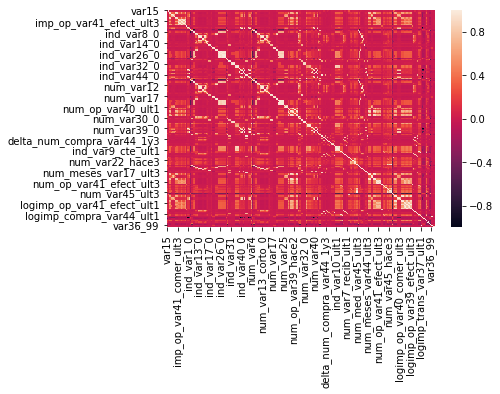

In [44]:
sns.heatmap(train_data.corr())

### 3.1 Удаляем коррелирующие друг с другом признаки

In [45]:
c = train_data.corr().abs().unstack()

In [46]:
c_df = pd.DataFrame(c.sort_values(ascending=False))\
            .reset_index()\
            .rename({'level_0': 'col1', 'level_1': 'col2', 0: 'val'}, axis=1)

columns = c_df[(c_df.val > 0.99) & (c_df.col1 != c_df.col2)]\
            .apply(lambda row: sorted([row['col1'], row['col2']]), axis=1)\
            .sort_values()

delete_columns = columns.apply(lambda x: x[1]).unique()

In [47]:
# Пока не удаляем
# train_corr_columns = train_means_columns[train_means_columns.columns.drop(delete_columns)]

### 4. Разбиваем выборку на тестовую и обучающую

In [48]:
from sklearn.model_selection import train_test_split

In [52]:
X = train_data.drop('TARGET', axis=1)
y = train_data['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.33, random_state=42)

### 5. Применяем стратегию Undersampling и Oversampling

In [53]:
# Библиотека для применения стратегии OVERSAMPLING
from imblearn.over_sampling import SMOTE

from imblearn.under_sampling import RandomUnderSampler

(array([48916.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  2017.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

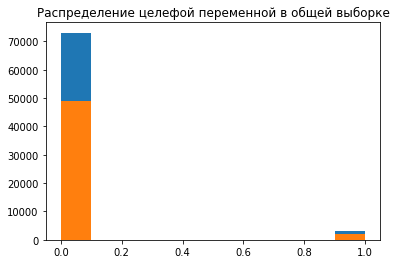

In [54]:
plt.title('Распределение целефой переменной в общей выборке')
plt.hist(y)

plt.hist(y_train)

Т.е получается, что в выборке крайне мало неудовлетворенных клиентов - это может привести к перекосу модели. Для того, чтобы такого перекоса при обучении не было, попробуем применить стратегию Undersampling (обучающая выборка достаточно большая и это не сильно повлияет на качество модели)

#### Применим стратегию Undersampling

In [55]:
X_resampled_u, y_resampled_u = RandomUnderSampler(random_state=42).fit_resample(X, y)

X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_resampled_u, y_resampled_u,  test_size=0.33, 
                                                            random_state=42)

(array([1979.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2051.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

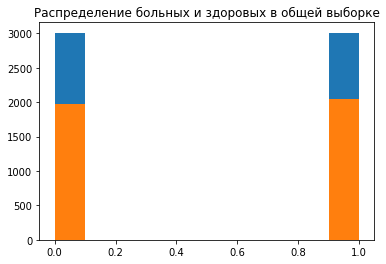

In [56]:
# Гистограмма общей выборки после применения стратегии OVERSAMPLING
plt.title('Распределение больных и здоровых в общей выборке')
plt.hist(y_resampled_u)

# Гистограмма обучающей выборки после применения стратегии OVERSAMPLING
plt.hist(y_train_u)

### 6 Строим модель для undersampling решения

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

#### Будем использовать GridSearch для выбора модели классификации RandomForest

In [58]:
model_forest = RandomForestClassifier()

In [59]:
n_estimators = [3,4,5,6]
min_samples_splits = [2,3,4,5]
min_samples_leafs = [1,2,3,4]

param_forest = dict(n_estimators=n_estimators,
                      min_samples_split=min_samples_splits,
                      min_samples_leaf=min_samples_leafs)

In [60]:
grid_forest = GridSearchCV(model_forest, param_forest, cv=10)
grid_forest.fit(X_train_u, y_train_u)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [3, 4, 5, 6], 'min_samples_split': [2, 3, 4, 5], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [61]:
model_forest = grid_forest.best_estimator_
model_forest.score(X_test_u, y_test_u)

0.7119838872104733

#### Готовим данные для загрузки в Kaggle

In [91]:
forest_predictions_u = model_forest.predict(X_test_u)

In [83]:
predictions = model_forest.predict(test_data)
df = pd.DataFrame.from_dict({'ID': test['ID'], 'TARGET': predictions})
df.to_csv('predictions.csv', index=False)

#### Линейная модель - логистическая регрессия

In [63]:
model_logreg = LogisticRegression(penalty='l1')

In [76]:
Cs = [1]
fit_intercepts = [False]
tols = [0.0001]

param_logreg = dict(C=Cs,
                    fit_intercept=fit_intercepts,
                    tol=tols)

In [77]:
grid_logreg = GridSearchCV(model_logreg, param_logreg, cv=10)
grid_logreg.fit(X_train_u, y_train_u)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1], 'fit_intercept': [False], 'tol': [0.0001, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [78]:
grid_logreg.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [79]:
model_logreg = grid_logreg.best_estimator_
model_logreg.score(X_test_u, y_test_u)

0.7200402819738168

In [80]:
model_logreg.fit(X_train_u, y_train_u)
model_logreg.score(X_test_u, y_test_u)

0.7200402819738168

#### Готовим данные для загрузки в Kaggle

In [92]:
logreg_predictions_u = model_logreg.predict(X_test_u)

In [114]:
logreg_predictions_proba = model_logreg.predict_proba(X_test_u)

In [85]:
predictions = model_logreg.predict(test_data)
df = pd.DataFrame.from_dict({'ID': test['ID'], 'TARGET': predictions})
df.to_csv('predictions.csv', index=False)

### 7. Feature importances для RandomForestClassificatior 

In [82]:
forest_fi = pd.DataFrame.from_dict({'columns': X_train.columns, 
                            'feature_importances': model_forest.feature_importances_})
forest_fi.sort_values('feature_importances', ascending=False).head(10)

,columns,feature_importances
0,var15,0.138268
195,var15mc,0.134628
171,mc0,0.070391
101,num_var30,0.067883
145,num_meses_var5_ult3,0.058865
66,num_var5,0.055454
170,num_var45_ult3,0.024048
143,num_med_var22_ult3,0.021544
179,logimp_op_var41_comer_ult3,0.019041
142,num_var22_ult3,0.018974


Максимальная корреляция между признаком и Target-переменной составляет 0,1 - что говорит о слабых линейных зависимостях между целевой функцией и переменными. Соответственно, необходимо применять нелинейные подходы для взаимодействия с данными

## Accuracy, F1-Score, Precision, Recall, Confusion Matrix

$$ Accuracy=P/N $$
где, P – количество документов по которым классификатор принял правильное решение, а N – размер обучающей выборки.

In [94]:
from sklearn.metrics import accuracy_score
# Точность для леса решений:
accuracy_score(y_test_u, forest_predictions_u)

0.7119838872104733

In [96]:
# Точность для логистической регрессии:
accuracy_score(y_test_u, logreg_predictions_u)

0.7200402819738168

### 10.2 F1-Score

Понятно что чем выше точность и полнота, тем лучше. Но в реальной жизни максимальная точность и полнота не достижимы одновременно и приходится искать некий баланс. Поэтому, хотелось бы иметь некую метрику которая объединяла бы в себе информацию о точности и полноте нашего алгоритма. 

F-мера представляет собой гармоническое среднее между точностью и полнотой. Она стремится к нулю, если точность или полнота стремится к нулю.

$$ F=2\dfrac{Precision×Recall}{Precision+Recall} $$

In [99]:
from sklearn.metrics import f1_score
# F1-score для дерева решений:
f1_score(y_test_u, forest_predictions_u)

0.7140000000000001

In [100]:
# F1-score для логистической регрессии:
f1_score(y_test_u, logreg_predictions_u)

0.717766497461929

### 10.3 Precision-Recall

Пусть

- TP — истино-положительное решение;
- TN — истино-отрицательное решение;
- FP — ложно-положительное решение;
- FN — ложно-отрицательное решение.
Тогда, точность и полнота определяются следующим образом:

$$ Precision=TP/(TP+FP) $$
$$ Recall=TP/(TP+FN) $$

Precision - количество истинно положительных результатов от количества модельно-положительных результатов (фактически точность модели)
Recall - количество истинно положительных относительно реально-положительных результатов (фактически отклик на реальность)



In [102]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

In [107]:
# для логистической регрессии
print("Для логистической регрессии: Precision = {0}; Recall = {1}".\
    format(precision_score(y_test_u, logreg_predictions_u), recall_score(y_test_u, logreg_predictions_u)))

# для дерева решений
print("Для дерева решений: Precision = {0}; Recall = {1}".\
    format(precision_score(y_test_u, forest_predictions_u), recall_score(y_test_u, forest_predictions_u)))

Для логистической регрессии: Precision = 0.6979269496544916; Recall = 0.7387669801462905
Для дерева решений: Precision = 0.6845637583892618; Recall = 0.7460815047021944


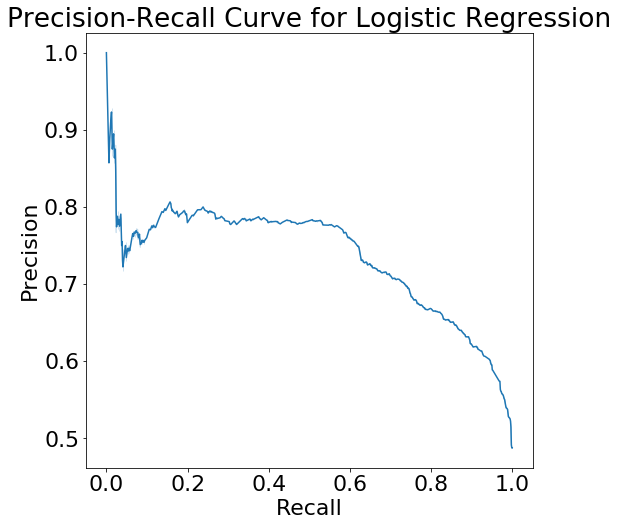

In [117]:
# Построим кривую Precision-Recall для Логистической регрессии
precision, recall, thresholds = precision_recall_curve(y_test_u, 
                                            [i[1] for i in logreg_predictions_proba])

plt.figure(figsize=(8,8))
plt.title('Precision-Recall Curve for Logistic Regression')
plt.rcParams.update({'font.size': 22})
plt.xlabel("Recall")
plt.ylabel("Precision")
sns.lineplot(recall, precision)

### 10.4 Confusion matrix (Матрица неточностей)

In [118]:
from sklearn.metrics import confusion_matrix

In [119]:
# Confusion matrix для линейной регрессии
confusion_matrix(y_test_u, logreg_predictions_u)

array([[723, 306],
       [250, 707]])

In [120]:
# Confusion matrix для дерева решений
confusion_matrix(y_test_u, forest_predictions_u)

array([[700, 329],
       [243, 714]])